In [1]:
import sys

# Specify the directory you want to add
custom_path = './..'

# Add the directory to sys.path
if custom_path not in sys.path:
    sys.path.append(custom_path)

from __future__ import absolute_import
import importlib

from copy import copy

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from types import SimpleNamespace

import matplotlib.pyplot as plt
from models import MLP, SymReLU
from dsp_utils import seg_time
from plt_utils import plot_by_key,plot_segments

from runners import Runner


/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
P0=0
Pplus=1
Pminus=-1
Pchannel=np.nan

T = 1500

playlist = {
'frogs': [(P0,T),((P0,Pplus),T),(P0,T)],
'anti_frogs': [(P0,T),(Pplus,T),(P0,T)],
'savings': 3 * [(P0, 500), (Pplus, 500)],
'sprecovery': [(P0, 192),
               (Pplus, 384),
               (Pminus, 20),
               (Pchannel, 400)],
'spOVRrecovery': [(P0, 192),
               (Pplus, 1000),
               (Pminus, 20),
               (Pchannel, 400)],
'evrecovery': [(P0, 192),
               (Pplus, 384),
               (Pminus, 20),
               (Pplus, 20),
               (Pchannel, 400)],
'lng_recovery': [(P0, 192),
               (Pplus, 384),
               (Pminus, 500),
               (Pchannel, 400)]
    }

In [3]:
baseline_settings = {'criterion':'MSE', 'k':[0.5,0,1], 'learning_rate':4e-3, 'sigma_noi':0.0, 'tau_u':10}
ff_settings = {'criterion':'MSE', 'k':[0,1,0], 'learning_rate':4e-3, 'sigma_noi':0.0, 'tau_u':10}

model_construct_args =  dict(n_inputs = 3,
                  n_hidden = 512,
                  n_outs = 1,
                  en_bias = False,
                 b_high=3, ones_first_layer=True,
                  nl = lambda : SymReLU(threshold=0.4))
test_vec= np.stack([np.linspace(-10,10,200), 
                    np.zeros(200),
                    np.zeros(200)]).T

In [4]:
baseline_runner = Runner(model_construct_args=model_construct_args,
                test_vec=test_vec,
                **baseline_settings)

model reset


In [5]:
ff_runner = Runner(model_construct_args=model_construct_args,
                test_vec=test_vec,
                **ff_settings)

model reset


In [6]:
results = baseline_runner.run_multiple(playlist)

running scenario: frogs
running scenario: anti_frogs
running scenario: savings
running scenario: sprecovery
running scenario: spOVRrecovery
running scenario: evrecovery
running scenario: lng_recovery


In [7]:
ff_results = ff_runner.run_multiple(playlist)

running scenario: frogs
running scenario: anti_frogs
running scenario: savings
running scenario: sprecovery
running scenario: spOVRrecovery
running scenario: evrecovery
running scenario: lng_recovery


In [8]:
def do_plots(results,playlist,figsize=(24, 6)):
    plt.figure(figsize=figsize)
    plt.subplot(1,3,1)
    plot_segments(results['savings'].u_lp,
              t_start=playlist['savings'][0][1],
              n_segments=3,
              t_increment=playlist['savings'][0][1]+playlist['savings'][1][1],
              t_segment=playlist['savings'][1][1],             
             )
    plt.subplot(1,3,2)
    plot_by_key(results, ['frogs','anti_frogs'],visu_offsets = [0, 0.0])
    plt.xlabel('epochs')
    plt.ylabel('u(epoch) [au]')
    plt.subplot(1,3,3)
    plot_by_key(results,
                ['sprecovery','spOVRrecovery','lng_recovery','evrecovery'],
                colors=['tab:red','tab:blue','tab:orange','tab:green'],
                align_end=True,
                visu_offsets=[0]*10,
               )


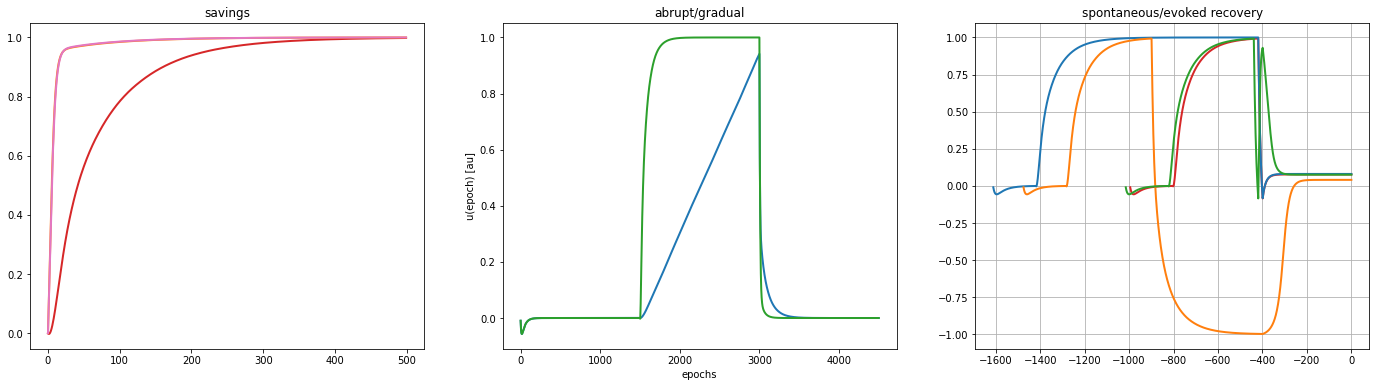

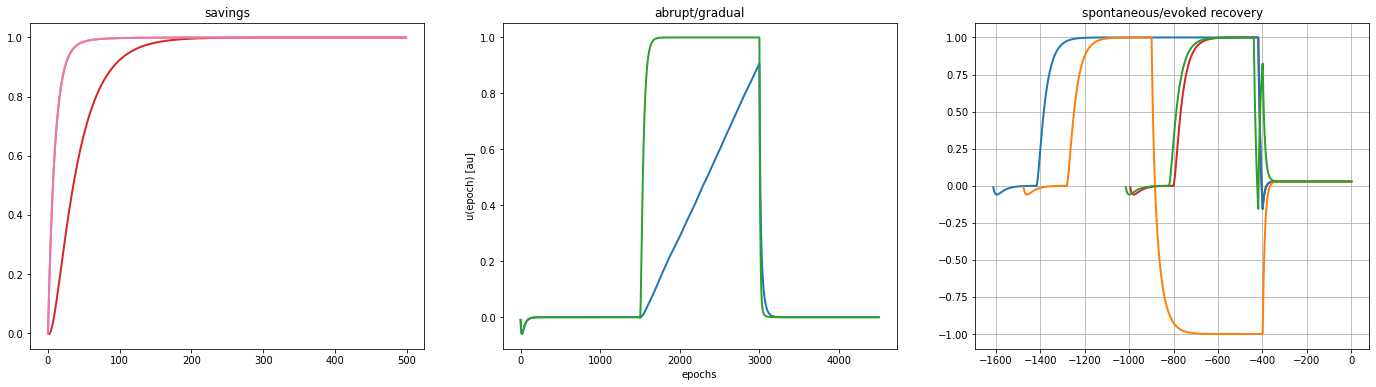

In [9]:
do_plots(results,playlist)
plt.subplot(1,3,1)
plt.title(f'savings')
plt.subplot(1,3,2)
plt.title(f'abrupt/gradual')
plt.subplot(1,3,3)
plt.title(f'spontaneous/evoked recovery')
plt.grid(True)
plt.show()


do_plots(ff_results,playlist)
plt.subplot(1,3,1)
plt.title(f'savings')
plt.subplot(1,3,2)
plt.title(f'abrupt/gradual')
plt.subplot(1,3,3)
plt.title(f'spontaneous/evoked recovery')
plt.grid(True)
plt.show()

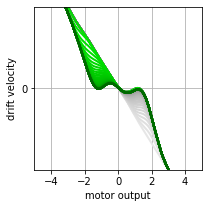

In [10]:
plt.figure(figsize=(3, 3))
foo = playlist['lng_recovery']
tau = baseline_runner.tau_u
test_sig = test_vec[:,0]
t_vec_Plus = np.arange(seg_time(foo,1,'start'),seg_time(foo,1,'end'),10)
t_vec_Pminus = np.arange(seg_time(foo,2,'start'),seg_time(foo,2,'end'),10)
for p,t_vec in enumerate([t_vec_Plus, t_vec_Pminus]):
  for i,t in enumerate(t_vec):
    shade = 0.9 - float(i) /2/ len(t_vec)
    plt.plot(test_sig, 1/tau*(results['lng_recovery'].test_output[t].squeeze()-test_sig),
            color=[0,shade,0] if p==1 else [shade,shade,shade],
            linewidth=2)
    plt.ylim([-0.3,0.3])
    plt.xlim([-5,5])
    plt.yticks([0])
plt.xlabel('motor output')
plt.ylabel('drift velocity')
plt.grid()

